# Membrane potentials

In [1]:
"""Further command line arguments:
        c       script will close all open plots
        sli     data of the original simulation written in sli will be analyzed. 
                Note that at this point, the data must be of the same simulation type, 
                as specifications are loaded from .npy-files of the pynest simulation. 

    Overview over all populations: Raster plot, mean rates, mean CV of ISI per population.
"""
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../presentation')) # include path with style
sys.path.append(os.path.abspath('../simulation/')) # include path with simulation specifications
import pres_style as style; reload(style)
import helper_functions as hf; reload(hf)

# Import specific moduls
import model_class; reload(model_class)

%matplotlib inline

show_fig = False
save_fig = True
xfactor = 2.6
style.rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83) 
figure_path = os.path.join(".", "figures")

reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3.py:215: Warning: Source ID 6 was not found when attempting to remove it
  GLib.source_remove(self._idle_event_id)


In [2]:
# DATA
sim_spec = "membrane_potential"
data_file = "micro"
data_sup_path = "/export/data-schuessler/data_microcircuit/"
data_path = os.path.join(data_sup_path, data_file)
data_file_name  = sim_spec + ".hdf5"  
res_file_name = sim_spec + "_res.hdf5"
path_data_file = os.path.join(data_path, data_file_name)
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types, 
    colors) = hf.basic_data(path_data_file)

## Plot membrane potentials

save figure to single_membrane_potential_L23e


/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


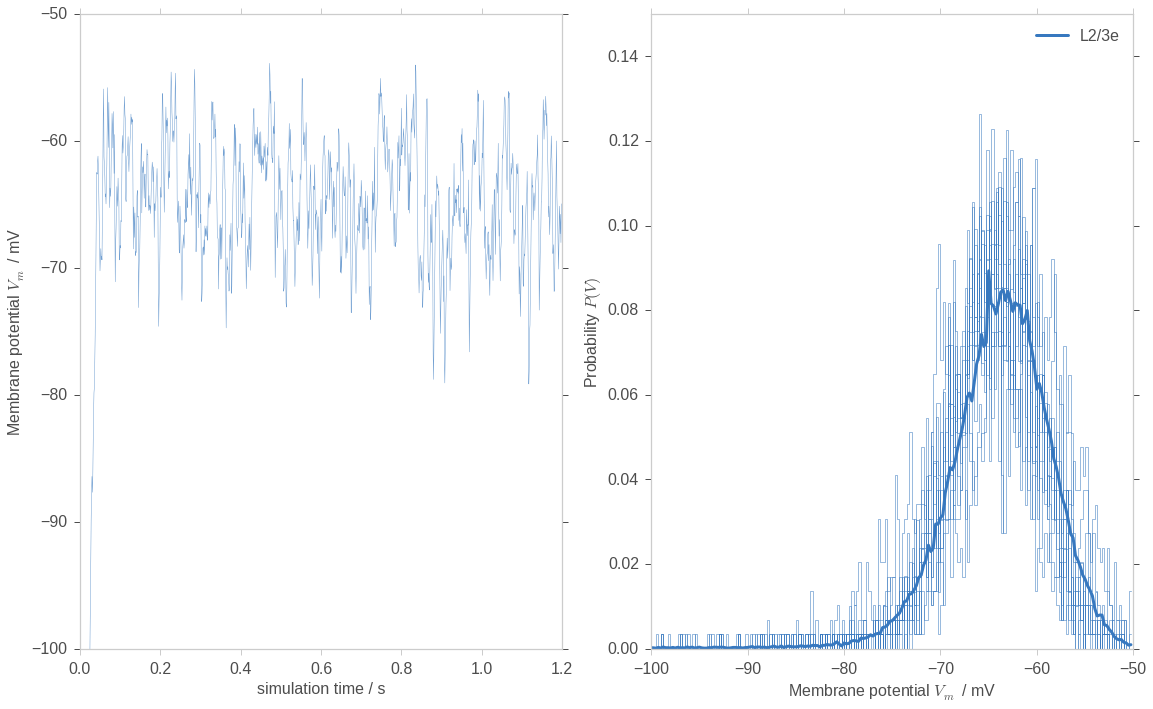

In [3]:
with h5py.File(path_res_file, "r") as res_file:
    res_grp = res_file["0"]
    
    dset_times_volt     = res_grp["times_volt"]
    times_volt = dset_times_volt[:]
    t_min_volt = dset_times_volt.attrs["t_min_volt"]
    t_max_volt = dset_times_volt.attrs["t_max_volt"]

    volt_plot         = res_grp["volt_plot"][:]
    volt_histo_single = res_grp["volt_histo_single"][:]
    dset_volt         = res_grp["volt_histo_means"]
    volt_histo_means  = dset_volt[:]
    V_min       = dset_volt.attrs["V_min"]
    V_max       = dset_volt.attrs["V_max"]
    n_bins_volt = dset_volt.attrs["n_bins_volt"]
    n_hist_max  = dset_volt.attrs["n_hist_max"]
    
bin_edges = np.linspace(V_min, V_max, n_bins_volt + 1) 

fig = plt.figure()
if not save_fig:
    suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
    suptitle += '\nfile: ' + sim_spec
    if sli: 
        suptitle += '  SLI'
    fig.suptitle(suptitle, y=0.98)
# Membrane pot over time
ax0 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
# Histogram of membrane pot
ax1 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

for i, population in enumerate(populations):
    if i==7:
    #if True:
        j = 0
        volt_single = volt_plot[i][j]
        ax0.plot(times_volt, volt_single, 
            '-', color=colors[i], alpha=0.7, linewidth=0.5, label=hf.rlbl(population))
        
        # Histograms
        for j in range(n_hist_max):
            ax1.plot(bin_edges[:-1], volt_histo_single[i, j], 
                 linewidth=1., color=colors[i], alpha=0.5, drawstyle="steps")
        ax1.plot(bin_edges[:-1], volt_histo_means[i], linewidth=3., color=colors[i], label=hf.rlbl(population))
        
# Potential over time
xlim = np.array([t_min_volt, t_max_volt]) # s
ax0.set_xlabel('simulation time / s')
ax0.set_ylabel('Membrane potential $V_m$ / mV')
ax0.set_xlim(*xlim)
ax0.set_ylim(V_min, V_max)

# Histogram
ax1.set_xlabel('Membrane potential $V_m$ / mV')
ax1.set_ylabel('Probability $P(V)$')
ax1.set_xlim(V_min, V_max)
ax1.set_ylim(0, 0.15)

ax1.legend(loc=0)
    
for ax in fig.axes:
    ax.grid(False)
    style.fixticks(ax)
    
fig_name = "single_membrane_potential"
fig_name += "_L23e"
if save_fig:
    hf.saving_fig(fig, figure_path, fig_name)  

## Mean field model solution:

In [4]:
# %load "../analysis/trans_mean_field.py"
def solve_model(model,
               v_guess_0=np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6]),
               root_function=None,
               jacobian=False, root_method='hybr', options=None):
    """Solve for model, given the initial guess v_guess_0.
    Returns solution = v0.
    """
    from scipy.optimize import root
    # Instantiation
    if jacobian:
        jac = model.jacobian
    else:
        jac = False

    # Run on initial guess v_guess_0
    if root_function=="siegert":
        sol = root(model.root_v0_siegert, v_guess_0, jac=jac, method=root_method, options=options)
    else:
        sol = root(model.root_v0, v_guess_0, jac=jac, method=root_method, options=options)
    if sol["success"]:
        print("intial success")
        v0  = sol["x"]
        if np.all(v0 < 1./model.t_ref): 
            return v0
        else:       # converged unphysically (v0 >= 1/t_ref)
            raise Exception("Converged unphysically for v_guess_0")
    else:   
        raise Exception("No solution found for v_guess_0")

        
#######################################################
# Global boundaries
#######################################################
connection_rule = "fixed_indegree"
PSC_rel_sd      = 0.0
model_micro       = model_class.model(connection_rule=connection_rule,
                                           PSC_rel_sd=PSC_rel_sd) 
v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])

t_int0      = time.time()
rate_mf = solve_model(model_micro, v_guess_0)
t_int1      = time.time() - t_int0
print("Integration time: %.2f"%(t_int1))

if reverse_order: 
    rate_mf = rate_mf[::-1] #reversed order!!!

intial success
Integration time: 0.03


In [5]:
def prob_V(V_array, mu_i, sd_i, v0_i, model=model_class.model()):
    """Membrane potential probability distribution P(V_m) according to Brunel"""
    from scipy.integrate import quad
    step        = lambda x: 0.5 * (np.sign(x) + 1)  # Heaviside step function
    red         = lambda V: (V - mu_i) / sd_i           # reduced voltage
    P_integrand = lambda u: step(u - red(model.V_r)) * np.exp(u**2) # integrand
    
    Vs = V_array - model.E_L # shift since Brunel's model is using E_L = 0
    
    # Integral boundaries
    lowers  = red(Vs)
    upper  = red(model.theta)
  
    integrals   = np.array([quad(P_integrand, lower, upper)[0] for lower in lowers])

    P_V_array   = 2 * v0_i * model.tau_m / sd_i * np.exp(- (Vs - mu_i)**2 / sd_i**2) * integrals
    
    return step(-Vs + model.theta) * P_V_array

L6i 7.57250375401 35.9505682729 5.83350189547 -3.59142221059 3.12193326132e+16


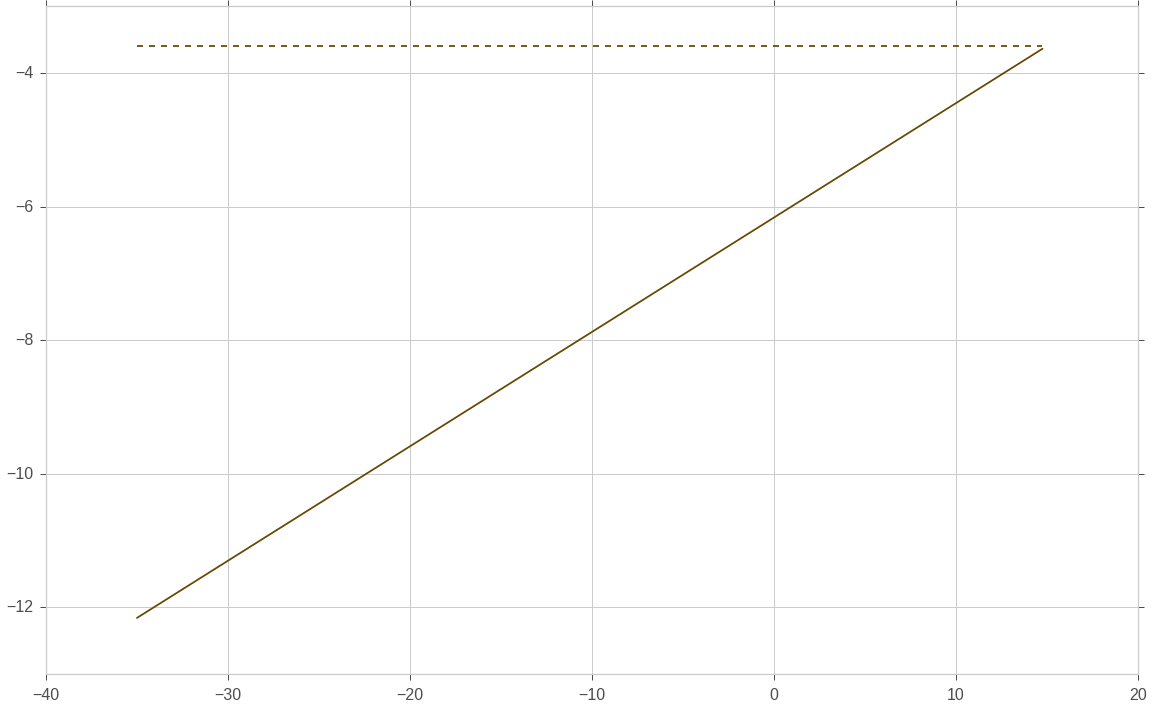

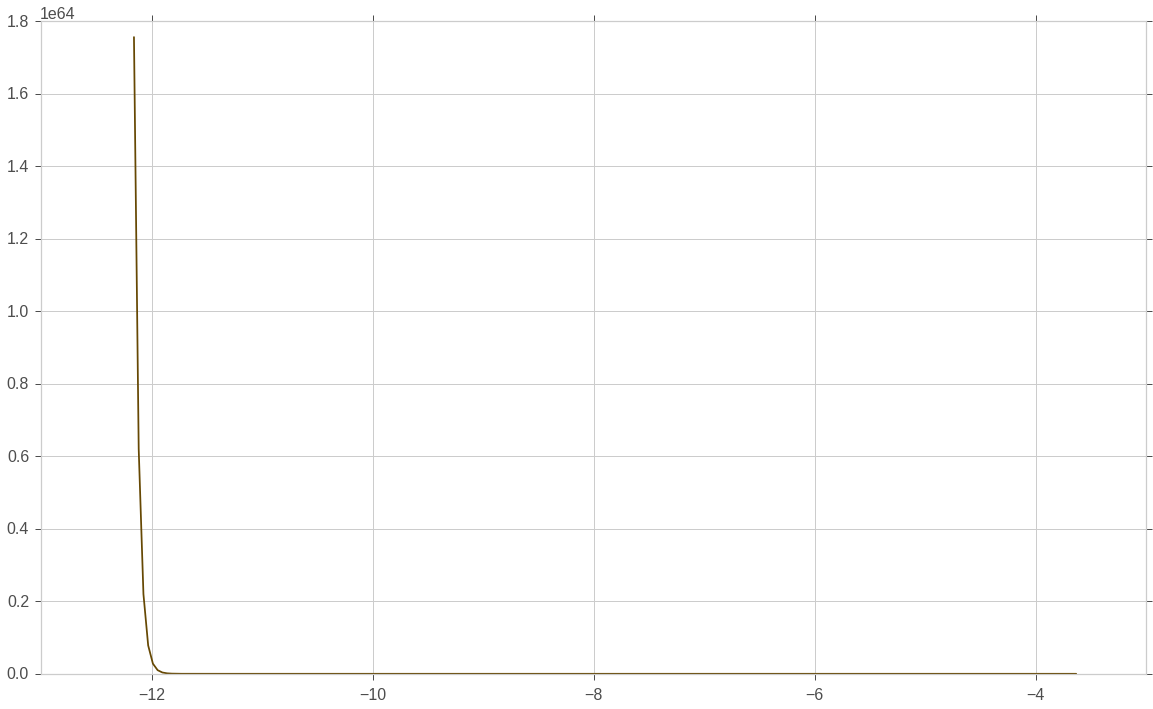

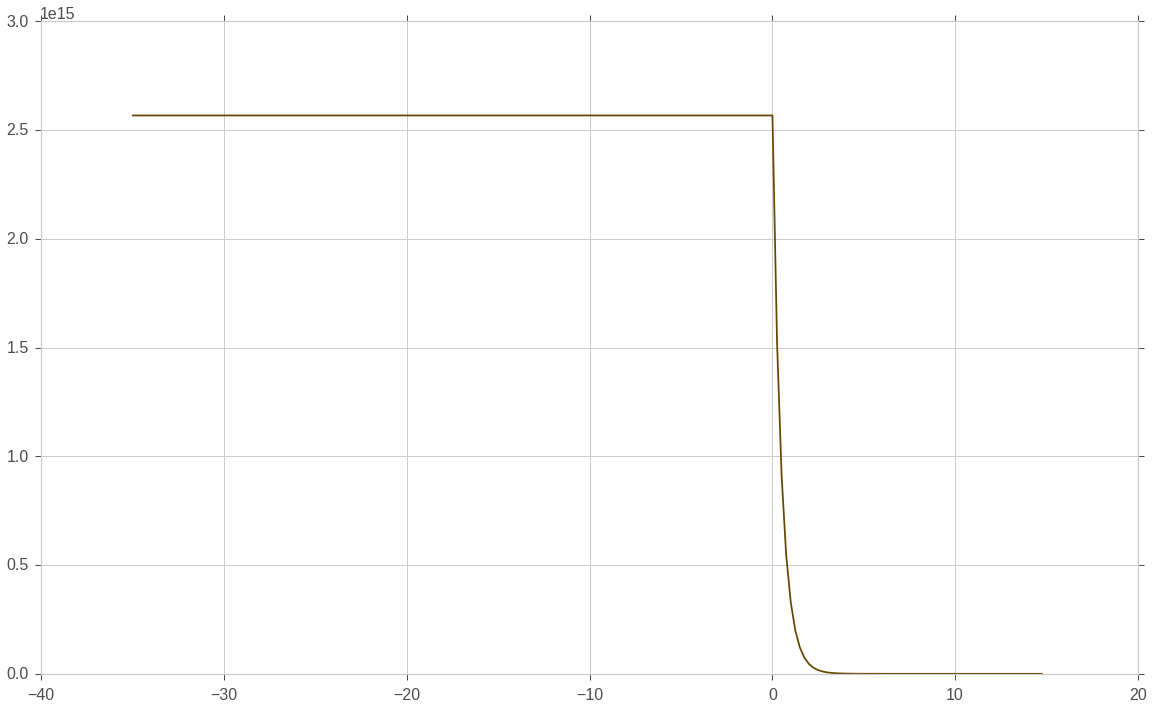

In [29]:
# Model
connection_rule = "fixed_indegree"
PSC_rel_sd      = 0.1 # 0.1 for micro
model           = model_class.model(connection_rule=connection_rule,
                                           PSC_rel_sd=PSC_rel_sd) 
V_array = bin_edges[:-1] 
Vs = V_array - model.E_L # shift since Brunel's model is using E_L = 0
    
mu_brunel   = model.mu(rate_mf)
sd_brunel   = model.sd(rate_mf)


"""Membrane potential probability distribution P(V_m) according to Brunel"""
from scipy.integrate import quad

#for i, population in enumerate(populations):
i = 0
population = populations[i]
if True:
    v0_i = rate_mf[i]
    mu_i = mu_brunel[i]
    sd_i = sd_brunel[i]
    
    step        = lambda x: 0.5 * (np.sign(x) + 1)  # Heaviside step function
    red         = lambda V: (V - mu_i) / sd_i           # reduced voltage
    P_integrand = lambda u: step(u - red(model.V_r)) * np.exp(u**2) # integrand

    # Integral boundaries
    lowers  = red(Vs)
    upper  = red(model.theta)

    integrals   = np.array([quad(P_integrand, lower, upper)[0] for lower in lowers])

    #P_V_array   = 2 * v0_i * model.tau_m / sd_i * np.exp(- (Vs - mu_i)**2 / sd_i**2) * integrals

    fig = plt.figure()
    ax1 = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
    ax1.plot(Vs, lowers, "-", color=colors[i], label=hf.rlbl(population))
    ax1.plot(Vs, [upper]*len(Vs), "--", color=colors[i], label=hf.rlbl(population))
    
    fig = plt.figure()
    ax1 = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
    ax1.plot(red(Vs), np.exp(((Vs - mu_i) / sd_i)**2), "-", color=colors[i], label=hf.rlbl(population))
    #ax1.set_xlim(mu_i / sd_i, )
    #ax1.set_ylim(0, np.exp(((model.V_r - mu_i) / sd_i)**2))    
    
    fig = plt.figure()
    ax1 = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
    ax1.plot(Vs, integrals, "-", color=colors[i], label=hf.rlbl(population))    
    

    print(population, v0_i, mu_i, sd_i, (model.theta - mu_i) / sd_i, np.exp(((model.V_r - mu_i) / sd_i)**2))


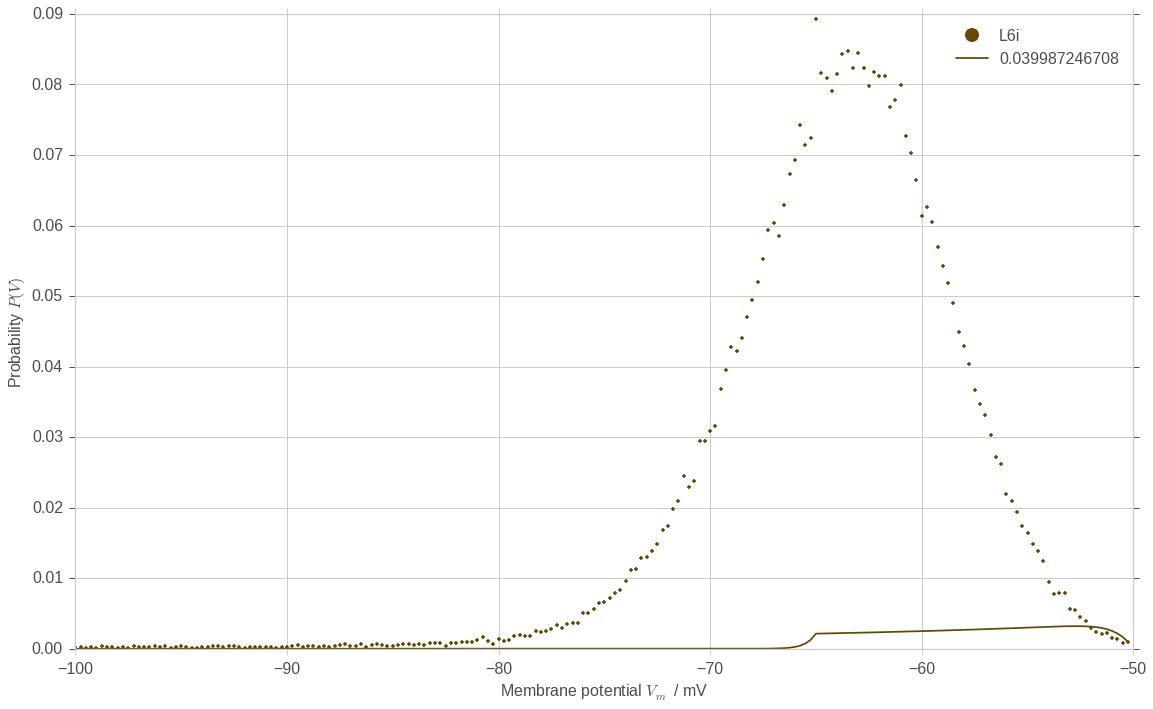

In [6]:
with h5py.File(path_res_file, "r") as res_file:
    res_file_name = sim_spec + "_res.hdf5"
    res_file = h5py.File(os.path.join(data_path, res_file_name), "r")
    sim_spec2 = "0"
    res_grp = res_file[sim_spec2]
    rates_mean   = res_grp["rates_mean"][:]
    rates_std    = res_grp["rates_std"][:]

# Model
connection_rule = "fixed_indegree"
PSC_rel_sd      = 0.1 # 0.1 for micro
model           = model_class.model(connection_rule=connection_rule,
                                           PSC_rel_sd=PSC_rel_sd) 

# Input according to Brunel
mu_brunel   = model.mu(rate_mf)
sd_brunel   = model.sd(rate_mf)
# and with simulated input
mu_sim      = model.mu(rates_mean)
sd_sim      = model.sd(rates_mean)

######
#TREAT OUTLIER BETTER
######

V_array = bin_edges[:-1]

#for i, population in enumerate(populations):
i = 0
population = populations[i]
if True:
    P_V_data =  volt_histo_means[::-1][i]
    
    # Theoretical distirbution using Brunel's mu and sd but measured rate v0
    #V_theo = prob_V(V_array, mu_sim[i], sd_sim[i], rates_mean[i], model=model)
    P_V_theo = prob_V(V_array, mu_brunel[i], sd_brunel[i], rate_mf[i], model=model)
    
    # calculate integral of P_theo(V)
    V_step = V_array[1] - V_array[0]
    P_cum = np.sum(P_V_theo) * V_step
    
    
    # Plotting
    fig = plt.figure()
    ax1 = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
    ax1.plot(V_array, P_V_data, ".", color=colors[i], label=hf.rlbl(population))
    ax1.plot(V_array, P_V_theo, "-", color=colors[i], label=P_cum)

    ax1.set_xlabel('Membrane potential $V_m$ / mV')
    ax1.set_ylabel('Probability $P(V)$')
    ax1.set_xlim(V_min, V_max)
    ax1.grid(True)
    ax1.legend(loc='best')
    
    for ax in fig.axes:
        style.fixticks(ax)
        
    fig_name = "membrane_potential_" + population
    if save_fig:
        hf.saving_fig(fig, figure_path, fig_name, verbose=False)  


0
Popul.	sim.	reduced fit	full fit        	mean field
      	rate.	           	with rates      	  
      	[  v0]	[ mu0  sd0]	[  v1]  [ mu1  sd1]	[ v_b]  [ mu_b sd_b]
L6i	[7.67]	[7.97 4.87]	[8.54]  [8.00 4.99]	[7.57]  [35.95 5.83]
L6e	[1.09]	[2.34 5.98]	[2.12]  [2.45 6.49]	[1.63]  [41.19 4.81]
L5i	[8.62]	[7.95 5.05]	[8.96]  [7.96 5.09]	[8.01]  [3.92 5.48]
L5e	[8.00]	[6.29 6.04]	[7.01]  [6.25 5.86]	[8.17]  [20.66 6.19]
L4i	[6.13]	[6.08 5.77]	[6.59]  [6.10 5.86]	[5.55]  [50.05 4.50]
L4e	[4.35]	[6.05 5.35]	[5.62]  [6.10 5.62]	[3.98]  [34.04 3.74]
L23i	[3.08]	[6.18 4.92]	[4.59]  [6.25 5.26]	[2.50]  [40.75 3.47]
L23e	[0.92]	[1.53 6.24]	[1.70]  [1.61 6.70]	[0.57]  [37.69 2.66]


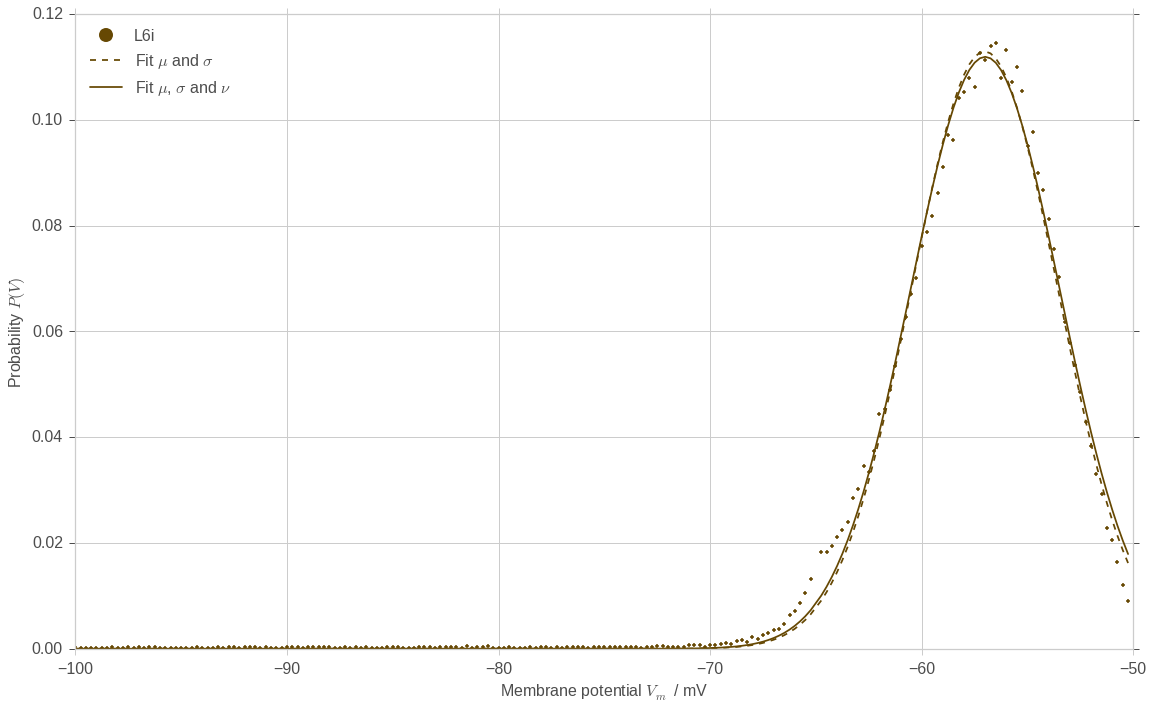

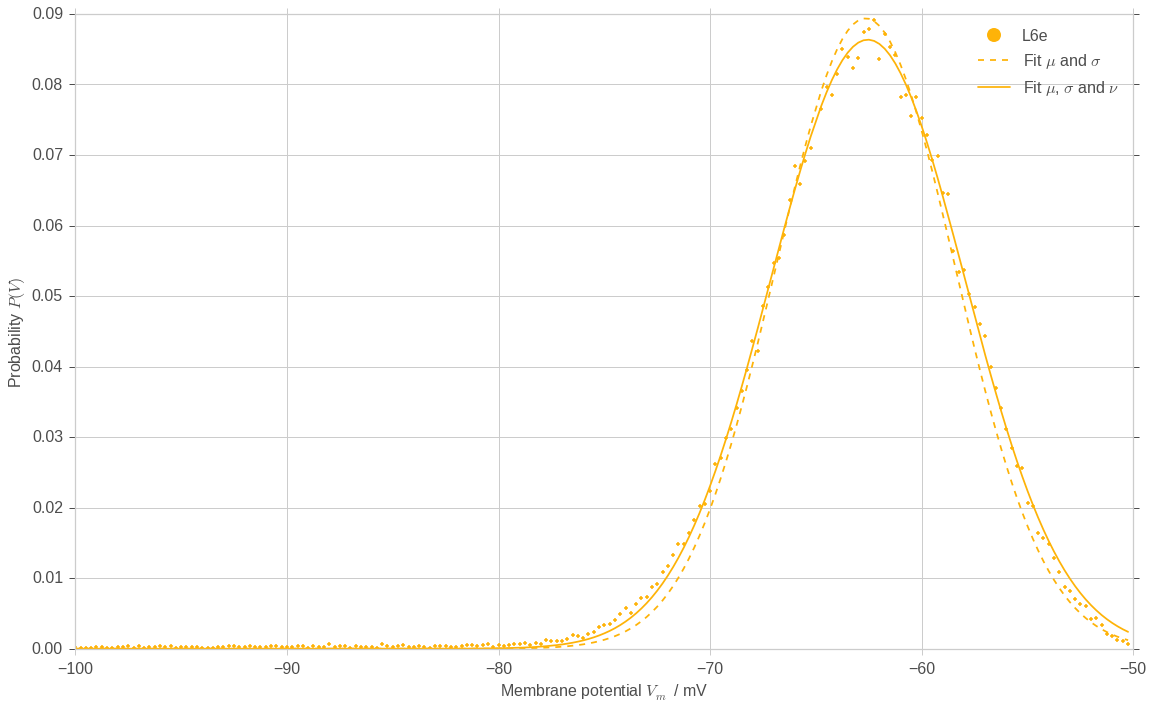

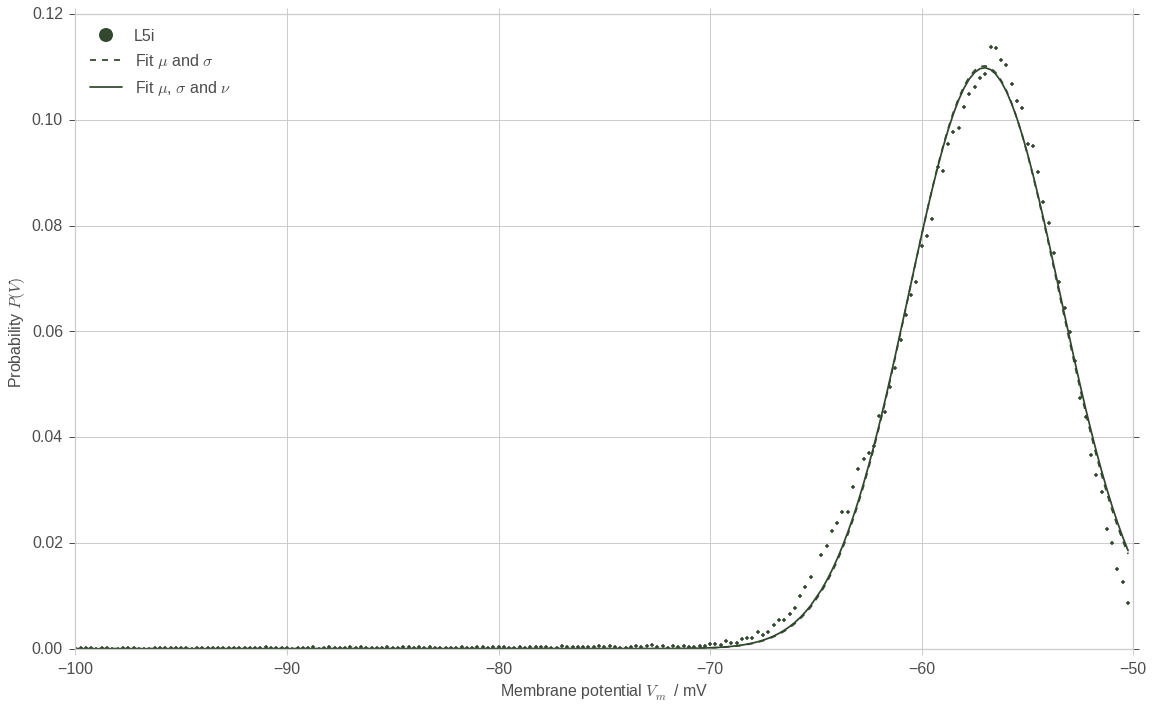

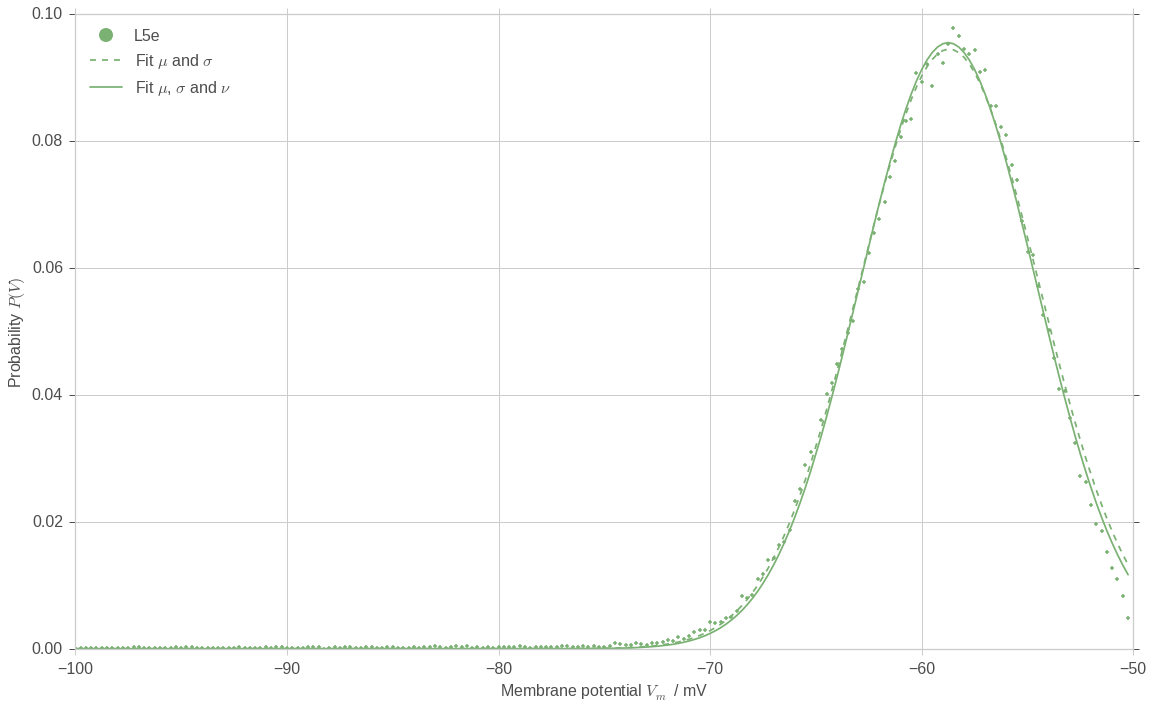

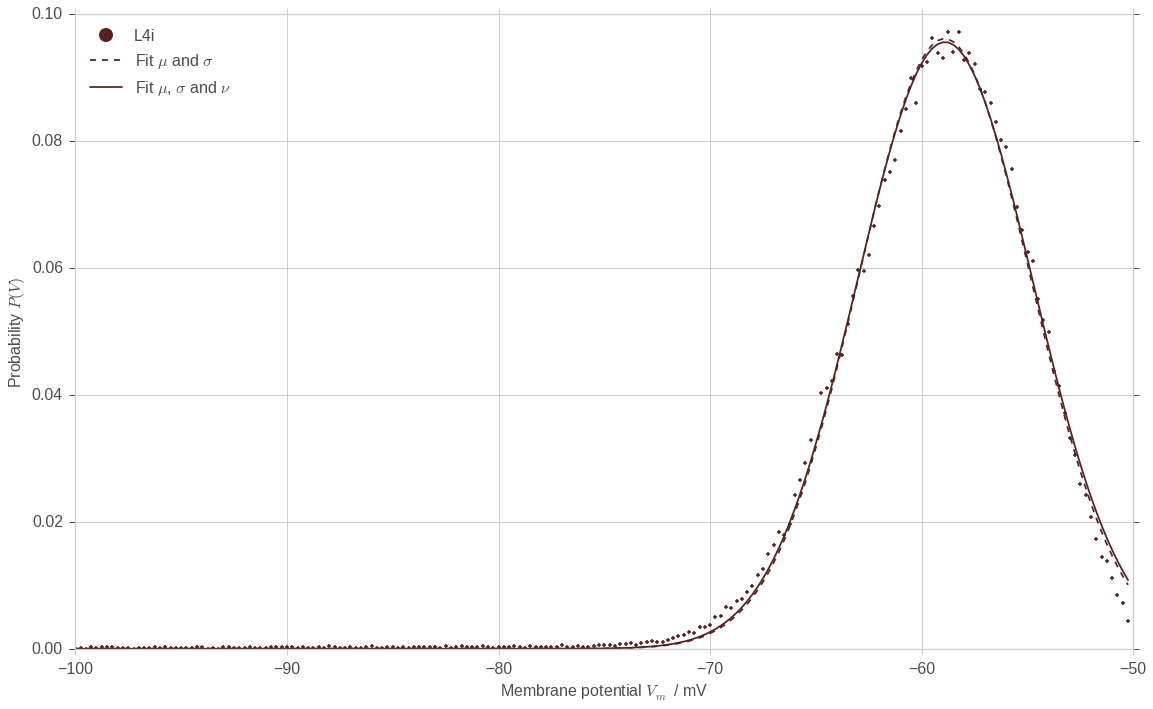

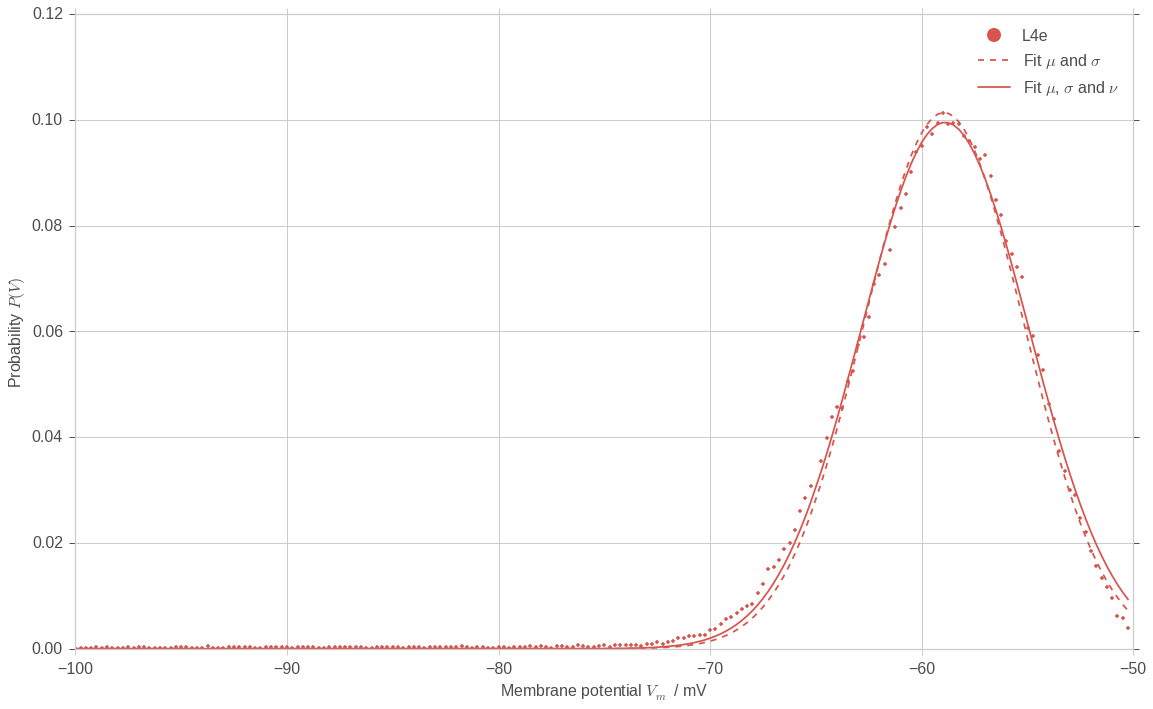

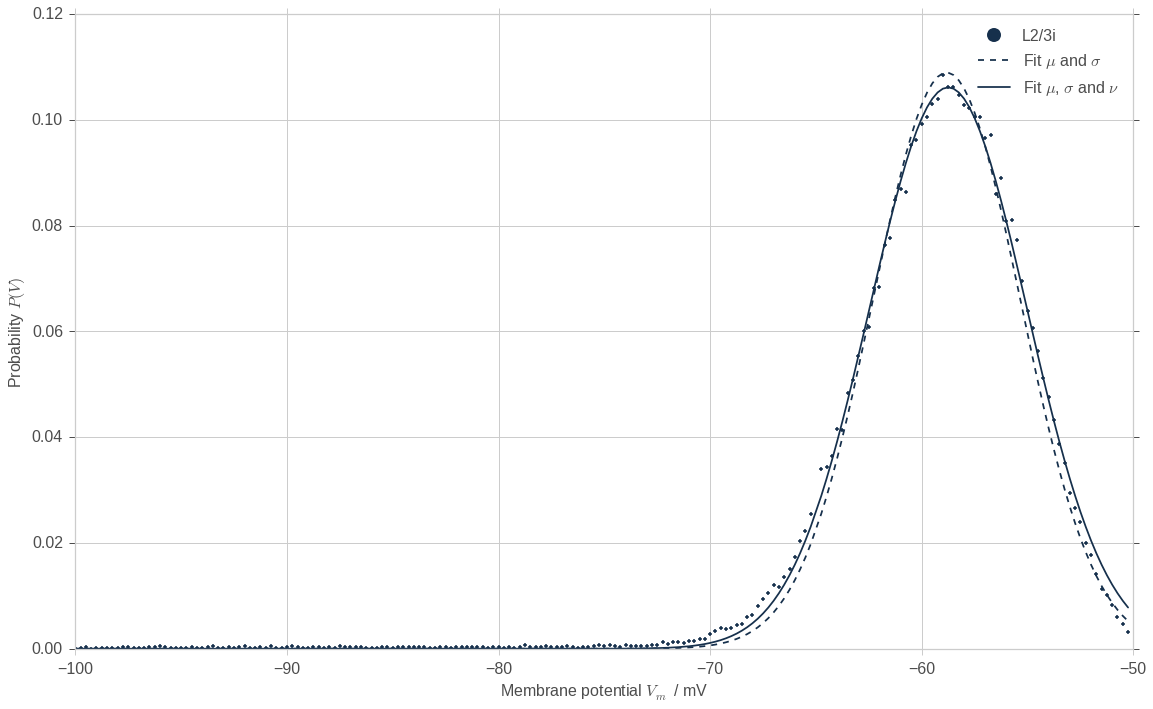

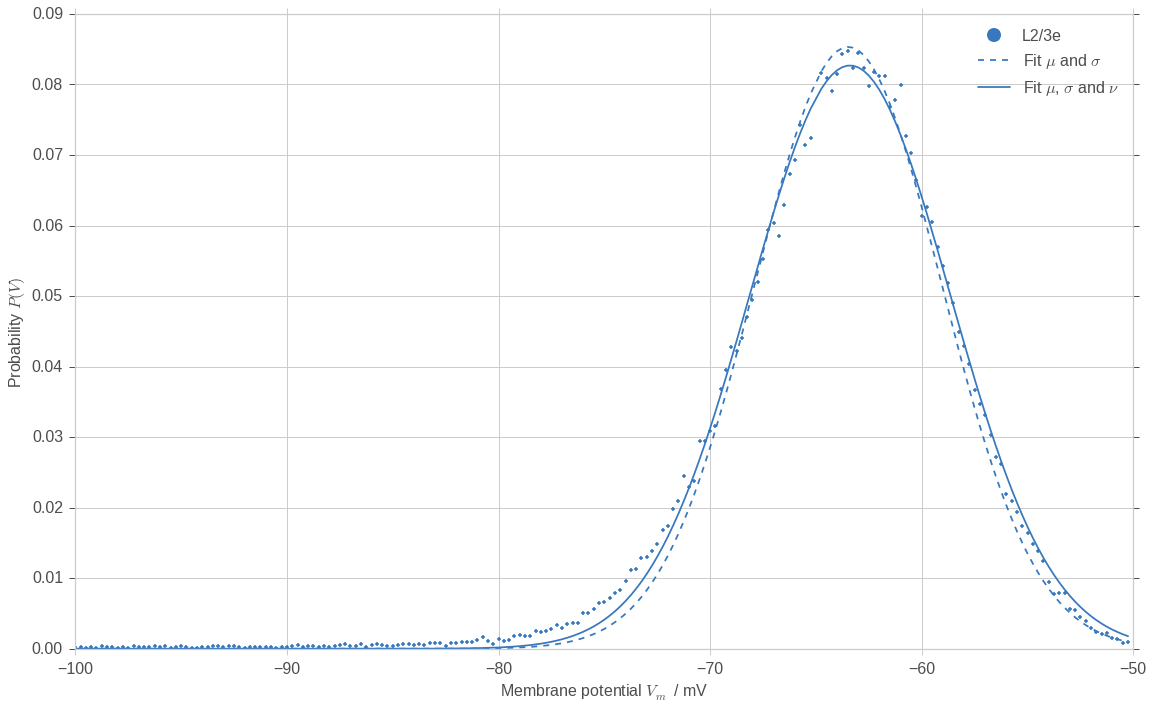

In [91]:
from scipy.optimize import curve_fit

# Open file: results
with h5py.File(path_res_file, "r") as res_file:
    res_file_name = sim_spec + "_res.hdf5"
    res_file = h5py.File(os.path.join(data_path, res_file_name), "r")
    sim_spec2 = "0"
    print(sim_spec2)
    res_grp = res_file[sim_spec2]

    rates_mean   = res_grp["rates_mean"][:]
    rates_std    = res_grp["rates_std"][:]

# Model
connection_rule = "fixed_indegree"
PSC_rel_sd      = 0.1 # 0.1 for micro

model           = model_class.model(connection_rule=connection_rule,
                                           PSC_rel_sd=PSC_rel_sd) 

# Input according to Brunel
mu_brunel = model.mu(rate_mf)
sd_brunel = model.sd(rate_mf)
# and with simulated input
mu_sim = model.mu(rates_mean)
sd_sim = model.sd(rates_mean)

V_array_full = bin_edges[:-1]
V_r_arg = np.argmin(np.abs(V_array_full - (model.V_r + model.E_L))) # outlier
V_array = np.delete(V_array_full, V_r_arg)

print("Popul.\tsim.\treduced fit\tfull fit        \tmean field")
print("      \trate.\t           \twith rates      \t  ")
print("      \t[  v0]\t[ mu0  sd0]\t[  v1]  [ mu1  sd1]\t[ v_b]  [ mu_b sd_b]")
for i, population in enumerate(populations):
    P_V_data = np.delete(volt_histo_means[i], V_r_arg) # Remove outlier due to V_r

    # Initial guess
    mu0 = 1 # V
    sd0 = 9 # V
    V_guess = model.prob_V(V_array, mu0, sd0, v=rates_mean[i])

    # Fit only mu and sd
    func = lambda V, mu, sd: model.prob_V(V, mu, sd, v=rates_mean[i])
    p0 = (1, 9)
    popt, pcov = curve_fit(func, V_array, P_V_data, p0=p0)
    V_opt = func(V_array, *popt)

    # Fit v, mu, sd
    func_v = lambda V, mu, sd, v: model.prob_V(V, mu, sd, v)
    p0 = (mu0, sd0, rates_mean[i])
    popt_v, pcov_v = curve_fit(func_v, V_array, P_V_data, p0=p0)
    V_opt_v = func_v(V_array, *popt_v)
    
    # Theoretical distirbution using Brunel's mu and sd but measured rate v0
    V_theo = model.prob_V(V_array, mu_brunel[i], sd_brunel[i], rates_mean[i])

    # Plotting
    fig = plt.figure()
    ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

    ax1.plot(V_array, P_V_data, ".", color=colors[i], label=hf.rlbl(population))
    #ax1.plot(V_array, V_guess, color=colors[i], label=hf.rlbl(population))
    ax1.plot(V_array, V_opt, "--", color=colors[i], label="Fit $\mu$ and $\sigma$")
    ax1.plot(V_array, V_opt_v, "-", color=colors[i], label="Fit $\mu$, $\sigma$ and $\\nu$")
    #ax1.plot(V_array, V_theo, "-.", color=colors[i], label=hf.rlbl(population))

    ax1.set_xlabel('Membrane potential $V_m$ / mV')
    ax1.set_ylabel('Probability $P(V)$')
    ax1.set_xlim(V_min, V_max)
    ax1.grid(True)
    ax1.legend(loc='best')
    
    for ax in fig.axes:
        style.fixticks(ax)
        
    fig_name = "membrane_potential_fit_" + population
    if save_fig:
        hf.saving_fig(fig, figure_path, fig_name, verbose=False)  
        
    # Printing
    results_str = population + "\t[%.2f]\t[%.2f %.2f]\t[%.2f]  [%.2f %.2f]\t[%.2f]  [%.2f %.2f]"%(rates_mean[i], 
                                                                popt[0], popt[1], 
                                                                popt_v[2], popt_v[0], popt_v[1], 
                                                                rate_mf[i], mu_brunel[i], sd_brunel[i])
    print(results_str)  